# Background:Linearization & Confidence Intervals

**What you'll do**
1. Simulate 2D diffusion (random walks), visualize, and estimate the diffusivity $D$ from the MSD.
2. Learn when linearization is appropriate and what “fit in the original space” means.
3. Fit **Arrhenius diffusion**: linearize ($\ln D$ vs $1/T$) and compute **95% t-intervals** and bands.
4. Fit **Stefan–Boltzmann**: log–log linearization (slope $\approx 4$) and compare with an **original-space** fit.

> All sections are modular: edit the parameters under the “CONFIG” blocks and rerun.


# Learning Goals

- Refresh connection between microscopic and macroscopic pictures of diffusion, and between discrete and continuous distributions.
- Relate moments of distribution to relevant physical quantities.
- Perform OLS regression on linearized diffusion equation.
- Introduce confidence intervals and their utility, compare with variance of estimators.

## Part 1 — 2D Diffusion via Random Walk

We simulate $N$ walkers on a 2D grid taking cardinal hops of length $a$ each time step $\Delta t$. Let $\mathbf{r}_i(t)$ be the position vector of particle $i$ at time $t$, and define the displacement
$$
\Delta \mathbf{r}_i(t) \;=\; \mathbf{r}_i(t) - \mathbf{r}_i(0).
$$

For a simple unbiased random walk in 2D, the mean squared displacement increases linearly with time:
$$
\mathrm{MSD}(t) \;=\; 4D\,t,\qquad
D \;=\; \frac{a^2}{4\,\Delta t},
$$

where $D$ is the diffusivity.

<br>

## Mean-squared displacement (MSD).

The MSD at time $t$ is the ensemble average of the squared displacement:
$$
\mathrm{MSD}(t)
\;=\;
\left\langle \, \lVert \Delta \mathbf{r}_i(t) \rVert^2 \, \right\rangle_i
\;=\;
\frac{1}{N}\sum_{i=1}^N \big\lVert \mathbf{r}_i(t) - \mathbf{r}_i(0) \big\rVert^2 .
$$

In 2D, with components $\mathbf{r}_i(t) = \big(x_i(t),\,y_i(t)\big)$,

$$
\big\lVert \mathbf{r}_i(t) - \mathbf{r}_i(0) \big\rVert^2
=
\big[x_i(t)-x_i(0)\big]^2 + \big[y_i(t)-y_i(0)\big]^2 .
$$

<br>

If all walkers start at the origin, this simplifies to

$$\mathrm{MSD}(t)=\frac{1}{N}\sum_i \big(x_i(t)^2+y_i(t)^2\big).$$

We will estimate $D$ from the slope of $\mathrm{MSD}(t)$ versus $t$, and visualize particle positions.


# 2D DIFFUSION SIMULATION

## CODE
``` python

# ------------------------- CONFIG (edit me) -------------------------
RNG_SEED    = 2      # reproducibility
N_WALKERS   = 5000   # number of particles
N_STEPS     = 400    # number of time steps
A_STEP      = 1.0    # hop length a
DT          = 1.0    # time per step Δt

```

In [ ]:
# 2D diffusion simulation with FOUR snapshot histograms (t=0, 30, 100, 300)
# shown BEFORE the MSD fit and the final positions heatmap.

import numpy as np
import matplotlib.pyplot as plt

# ------------------------- CONFIG (edit me) -------------------------
RNG_SEED    = 2      # reproducibility
N_WALKERS   = 5000   # number of particles
N_STEPS     = 400    # number of time steps
A_STEP      = 1.0    # hop length a
DT          = 1.0    # time per step Δt

# Snapshot times (in steps) to visualize 2D position histograms, left→right
SNAP_TIMES  = [0, 30, 100, 300]

SHOW_HEATMAP = True  # plot 2D histogram of final positions (separate from snapshots)
GRID_BINS    = 60    # bins per axis for hist2d
# -------------------------------------------------------------------

np.random.seed(RNG_SEED)
x = np.zeros(N_WALKERS, dtype=float)
y = np.zeros(N_WALKERS, dtype=float)

msd = np.zeros(N_STEPS+1, dtype=float)
msd[0] = np.mean(x**2 + y**2)

# Keep snapshots of positions at requested times
# (clip to those within [0, N_STEPS])
snap_times = [t for t in SNAP_TIMES if 0 <= t <= N_STEPS]
snapshots = {0: (x.copy(), y.copy())} if 0 in snap_times else {}

dirs = np.random.randint(0, 4, size=(N_STEPS, N_WALKERS))

for t in range(1, N_STEPS+1):
    d = dirs[t-1]
    # right/left
    x += np.where(d==1,  A_STEP, np.where(d==3, -A_STEP, 0.0))
    # up/down
    y += np.where(d==0,  A_STEP, np.where(d==2, -A_STEP, 0.0))
    msd[t] = np.mean(x**2 + y**2)

    if t in snap_times:
        snapshots[t] = (x.copy(), y.copy())



## TIME SERIES

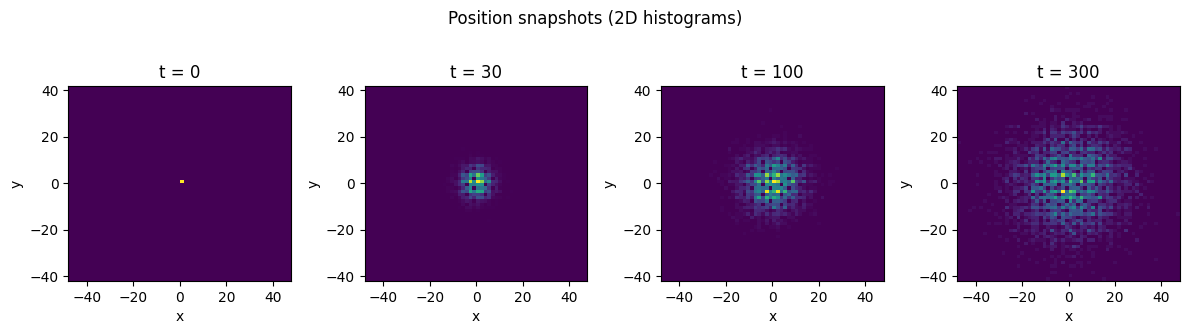

In [ ]:
# ------------------------- Snapshot panel (1×4) -------------------------
# Build a 1x4 set of 2D histograms for the chosen times (left→right).
# If fewer than 4 times are valid, we still plot the available ones.

# Use a consistent axis range across snapshots
all_x = np.concatenate([snapshots[t][0] for t in snap_times])
all_y = np.concatenate([snapshots[t][1] for t in snap_times])
pad = 1.0
xmin, xmax = all_x.min() - pad, all_x.max() + pad
ymin, ymax = all_y.min() - pad, all_y.max() + pad

# Make the plots
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, t in zip(axes.ravel(), snap_times + [None]*(4 - len(snap_times))):
    if t is None:
        ax.axis("off")
        continue
    xi, yi = snapshots[t]
    ax.hist2d(xi, yi, bins=GRID_BINS, range=[[xmin, xmax], [ymin, ymax]])
    ax.set_title(f"t = {t}")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
fig.suptitle("Position snapshots (2D histograms)", y=1.05)
fig.tight_layout()
plt.show()

## MEAN SQUARED DISPLACEMENT FIT

Theoretical D = 0.2500
Estimated  D  = 0.2498   (from MSD slope/4)
MSD intercept ≈ -0.17 (should be near 0 for t=0)


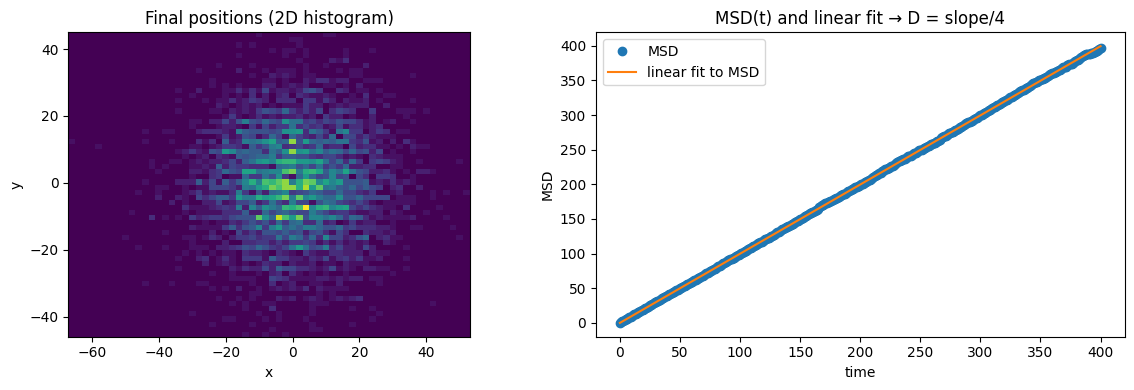

In [ ]:
# ------------------------- MSD fit and D estimate -------------------------
D_theory = (A_STEP**2) / (4.0 * DT)
t_arr = np.arange(N_STEPS+1) * DT
slope, intercept = np.polyfit(t_arr, msd, 1)  # MSD ≈ slope * t + intercept
D_est = slope / 4.0

print(f"Theoretical D = {D_theory:.4f}")
print(f"Estimated  D  = {D_est:.4f}   (from MSD slope/4)")
print(f"MSD intercept ≈ {intercept:.2f} (should be near 0 for t=0)")

# Side-by-side figure: left = final positions heatmap, right = MSD with fit
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: final positions heatmap
axes[0].hist2d(x, y, bins=GRID_BINS)
axes[0].set_aspect("equal", adjustable="box")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("Final positions (2D histogram)")

# Right: MSD vs time with linear fit
axes[1].plot(t_arr, msd, marker='o', linestyle='', label="MSD")
tt = np.linspace(t_arr.min(), t_arr.max(), 200)
axes[1].plot(tt, slope*tt + intercept, label="linear fit to MSD")
axes[1].set_xlabel("time")
axes[1].set_ylabel("MSD")
axes[1].set_title("MSD(t) and linear fit → D = slope/4")
axes[1].legend()

fig.tight_layout()
plt.show()


## Continuum Picture

The diffusion equation for the particle density $\rho(x, t)$ in one dimension is given by:

$$
\frac{\partial \rho}{\partial t} = D \frac{\partial^2 \rho}{\partial x^2}
$$

For particles starting at the origin at $t=0$, the solution to this equation is a Gaussian distribution:

$$
\rho(x, t) = \frac{1}{\sqrt{4 \pi D t}} \exp\left(-\frac{x^2}{4 D t}\right)
$$

<br>

- This Gaussian solution has a mean (first moment) of zero, consistent with unbiased diffusion.
- By inspection, the variance (second moment) of this distribution is $\langle x^2 \rangle = 2Dt$, giving the evolution in time.

In 2D, the MSD is $\langle r^2 \rangle = \langle x^2 + y^2 \rangle = \langle x^2 \rangle + \langle y^2 \rangle = 2Dt + 2Dt = 4Dt$. This shows that the MSD is directly proportional to the variance of the spatial distribution and increases linearly with time, which is what we observed in the simulation.

# Part 2 — Arrhenius Diffusion: Linearized Fit with Confidence Intervals

## Model

$$D(T) = D_0 \exp\!\left(-\frac{Q}{RT}\right).$$  
We simulate **multiplicative** noise so that $\ln D$ has approximately constant variance, then fit
$$
y=\ln D, \quad x=\frac{1}{T}, \quad y \approx \beta_0 + \beta_1 x + \eta_i,
$$

with $\beta_0=\ln D_0$ and $\beta_1=-Q/R$.

$$
\qquad \eta_i \sim \mathcal N(0,\sigma_{\ln}^2)\ \text{i.i.d.}
$$



## Expanded model

**Model (noiseless):**
$$
D(T) \;=\; D_0 \exp\!\left(-\frac{Q}{RT}\right).
$$

**Textbook-style multiplicative noise.** Let the observed diffusion coefficient be

$$
D_{\text{obs}}(T_i) \;=\; D(T_i)\,\varepsilon_i,
\qquad
\varepsilon_i \;=\; e^{\eta_i},\;\; \eta_i \sim \mathcal N(0,\sigma_{\ln}^2).
$$

Taking logs turns the multiplicative factor into an **additive** term:

$$
\ln D_{\text{obs}}(T_i)
\;=\;
\underbrace{\ln D_0 - \frac{Q}{R}\,\frac{1}{T_i}}_{\displaystyle \ln D_{\text{clean}}(T_i)}
\;+\;
\underbrace{\eta_i}_{\text{zero-mean noise in log space}}.
$$

Define
$$
x_i \;=\; \frac{1}{T_i}, \qquad
y_i \;=\; \ln D_{\text{obs}}(T_i), \qquad
\beta_0 \;=\; \ln D_0,\quad
\beta_1 \;=\; -\frac{Q}{R}.
$$

Then the **linear** model in log space is

$$
y_i \;=\; \beta_0 + \beta_1 x_i + \eta_i,
\qquad \eta_i \sim \mathcal N(0,\sigma_{\ln}^2)\ \text{i.i.d.}
$$

This justifies **ordinary least squares (OLS)** on $(x_i, y_i)$ because the variance in log space is (approximately) constant.



## Mapping to the code

In the notebook we simulate as:
```python
lnD_clean = np.log(D0_true) - Q_true/(R*T)          # = β0 + β1 x
lnD       = lnD_clean + rng.normal(0.0, sigma_ln, size=T.size)  # + η
```

Because $\eta_i \sim \mathcal N(0,\sigma_{\ln}^2)$,
$\mathbb{E}[\ln D_{\text{obs}}]=\ln D_{\text{clean}}$ (unbiased in log space) but
$\mathbb{E}[\varepsilon]=e^{\sigma_{\ln}^2/2}>1$, so
$\mathbb{E}[D_{\text{obs}}]=D_{\text{clean}}\cdot e^{\sigma_{\ln}^2/2}$.
This is another reason to fit in log space when the physical noise is multiplicative.

# Part 2: Initial Simulation

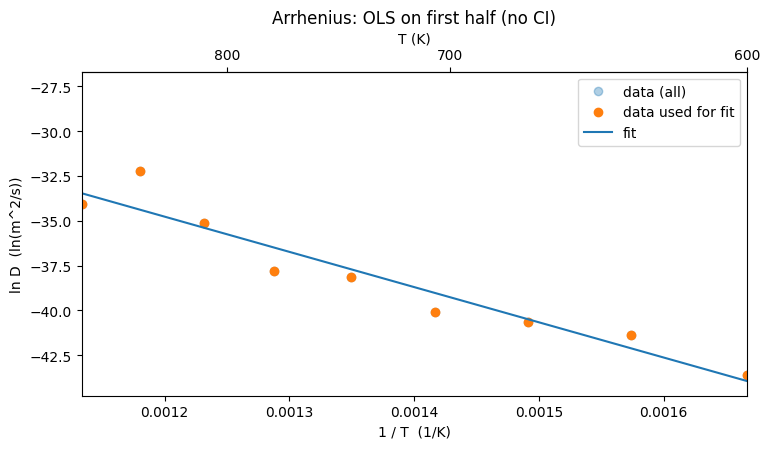

Fit mode: first_half, n_fit = 9, df = 7
Effective ln-noise σ ≈ 1.014  (ERRBAR_SIGMAS=1.0)
beta0 = ln D0 = -11.2183 ± 7.1545
beta1 = -Q/R  = -1.9629e+04 ± 5.1812e+03
D0_hat = 1.343e-05 ± 9.606e-05
Q_hat  = 163.2 ± 43.1  kJ/mol


In [ ]:
# --- Arrhenius (isolated) — linearized fit with adjustable noise, subset fit,
#     optional error bars and 95% CI band, plus top axis in T. ---
# This cell is self-contained: it DOES NOT reuse global T/lnD variables.
# All arrays are prefixed with _A to avoid collisions.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Import ticker

# ------------------------------ CONFIG (edit me) ------------------------------
R_A          = 8.31446261815324        # J/(mol·K)
Q_true_A     = 1.60e5                  # J/mol
D0_true_A    = 1.0e-5                  # m^2/s
N_T_A        = 18                      # number of temperature points
T_MIN_A      = 600.0                   # K
T_MAX_A      = 1200.0                   # K
RNG_SEED_A   = 7
SIGMA_LN_A   = 0.15                    # base SD of noise in ln D

NOISE_SCALE  = 10.0                    # 1.0 keeps base noise; >1 amplifies; <1 reduces
FIT_MODE     = "first_half"                   # "first_half" or "all"

# Plot toggles (like the simple OLS example)
SHOW_ERRORBARS = False                  # draw vertical error bars on the data
ERRBAR_ON      = "fit"                 # "fit", "all", "both", or "none"
ERRBAR_SIGMAS  = 1.0                   # errorbar size in units of ln-space SD (σ)
ERRBAR_CAPSIZE = 2.0
SHOW_CI_BAND   = False                  # show/hide the 95% confidence band (mean only)

ALPHA_CI       = 0.05                  # for 95% intervals (t critical)
# ------------------------------------------------------------------------------

# --------------------------- Simulate Arrhenius data --------------------------
rng_A = np.random.default_rng(RNG_SEED_A)
T_A = np.linspace(T_MIN_A, T_MAX_A, N_T_A)              # K
x_A = 1.0 / T_A                                         # 1/K

lnD_clean_A = np.log(D0_true_A) - Q_true_A / (R_A * T_A) #
eta_A       = rng_A.normal(0.0, SIGMA_LN_A, size=T_A.size)
lnD_A       = lnD_clean_A + NOISE_SCALE * eta_A         # scaled multiplicative noise in ln-space
y_A         = lnD_A

# ------------------------------ Choose fit subset -----------------------------
n_A = x_A.size
if FIT_MODE == "first_half":
    mask_fit_A = np.zeros(n_A, dtype=bool)
    mask_fit_A[: n_A//2] = True       # first half by index (change to x-sort if preferred)
elif FIT_MODE == "all":
    mask_fit_A = np.ones(n_A, dtype=bool)
else:
    raise ValueError("FIT_MODE must be 'first_half' or 'all'.")

x_fit_A, y_fit_A = x_A[mask_fit_A], y_A[mask_fit_A]

# ---------------------------------- OLS in ln-space ---------------------------
X_fit_A = np.column_stack([np.ones_like(x_fit_A), x_fit_A])
A_A     = X_fit_A.T @ X_fit_A
b_A     = X_fit_A.T @ y_fit_A
beta_A  = np.linalg.solve(A_A, b_A)                 # [beta0, beta1]
yhat_fit_A = X_fit_A @ beta_A
resid_fit_A = y_fit_A - yhat_fit_A

n_fit_A, p_A = X_fit_A.shape
nu_A = n_fit_A - p_A
SSE_A = float(np.sum(resid_fit_A**2))
sigma2_hat_A = SSE_A / nu_A
XtX_inv_A = np.linalg.inv(A_A)

# t-critical (SciPy if present; else ~1.96)
try:
    from scipy import stats
    tstar_A = stats.t.ppf(1 - ALPHA_CI/2, nu_A)
except Exception:
    tstar_A = 1.96

# --------------------------------- Plot domain --------------------------------
xx_A  = np.linspace(x_fit_A.min(), x_fit_A.max(), 250)
Xx_A  = np.column_stack([np.ones_like(xx_A), xx_A])
yfit_A = Xx_A @ beta_A

# Confidence band (mean-only), if enabled
if SHOW_CI_BAND:
    h_A = np.sum(Xx_A @ XtX_inv_A * Xx_A, axis=1)
    se_mean_A = np.sqrt(sigma2_hat_A * h_A)

# Effective ln-space noise SD (for error bars). Use sample SD of scaled noise:
sigma_ln_eff_A = float(np.std(NOISE_SCALE * eta_A, ddof=1))

# ------------------------------------ Plot ------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7.8, 4.6))

# ALL points
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"all", "both"}:
    ax.errorbar(x_A, y_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, alpha=0.35, label=f"data (all) ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_A, y_A, alpha=0.35, label="data (all)")

# FIT subset
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"fit", "both"}:
    ax.errorbar(x_fit_A, y_fit_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, label=f"data used for fit ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_fit_A, y_fit_A, label="data used for fit")

# Fit line
ax.plot(xx_A, yfit_A, label="fit")

# 95% CI (mean) if requested
if SHOW_CI_BAND:
    ax.plot(xx_A, yfit_A - tstar_A*se_mean_A, label="95% CI (mean)")
    ax.plot(xx_A, yfit_A + tstar_A*se_mean_A)

# Axes and title
ax.set_xlim(xx_A.min(), xx_A.max())
ax.set_xlabel("1 / T  (1/K)")
ax.set_ylabel("ln D  (ln(m^2/s))")
title_ci_A = "with 95% CI" if SHOW_CI_BAND else "no CI"
ax.set_title(f"Arrhenius: OLS on {FIT_MODE.replace('_',' ')} ({title_ci_A})")

# Top x-axis showing temperature: s = 1/T  <->  T = 1/s
# Use a custom formatter to display temperature on the secondary axis
def invT_formatter(x, pos):
    if x == 0:
        return 'inf'
    return f"{1.0/x:.0f}" # Format as integer temperature

secax_A = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x)) # Use identity function as we will control formatting

# Set the major tick locations on the secondary axis to be every 100 degrees
temp_ticks = np.arange(600, 1300, 100) # Generate temperatures from 600 to 1200 with step 100
inv_temp_ticks = 1.0 / temp_ticks # Convert temperatures to inverse temperatures
secax_A.set_xticks(inv_temp_ticks)

secax_A.xaxis.set_major_formatter(ticker.FuncFormatter(invT_formatter))
secax_A.set_xlabel("T (K)")

ax.legend()
fig.tight_layout()
plt.show()

# ------------------------- Parameter estimates & SEs --------------------------
beta0_A, beta1_A = beta_A
D0_hat_A = np.exp(beta0_A)     # delta method
Q_hat_A  = -beta1_A * R_A

se_beta_A = np.sqrt(np.diag(sigma2_hat_A * XtX_inv_A))
se_D0_A = D0_hat_A * se_beta_A[0]     # delta method
se_Q_A  = R_A * se_beta_A[1]


print(f"Fit mode: {FIT_MODE}, n_fit = {n_fit_A}, df = {nu_A}")
print(f"Effective ln-noise σ ≈ {sigma_ln_eff_A:.3f}  (ERRBAR_SIGMAS={ERRBAR_SIGMAS})")
print(f"beta0 = ln D0 = {beta0_A:.4f} ± {tstar_A*se_beta_A[0]:.4f}")
print(f"beta1 = -Q/R  = {beta1_A:.4e} ± {tstar_A*se_beta_A[1]:.4e}")
print(f"D0_hat = {D0_hat_A:.3e} ± {tstar_A*se_D0_A:.3e}")
print(f"Q_hat  = {Q_hat_A/1e3:.1f} ± {tstar_A*se_Q_A/1e3:.1f}  kJ/mol")

# With Error Bars

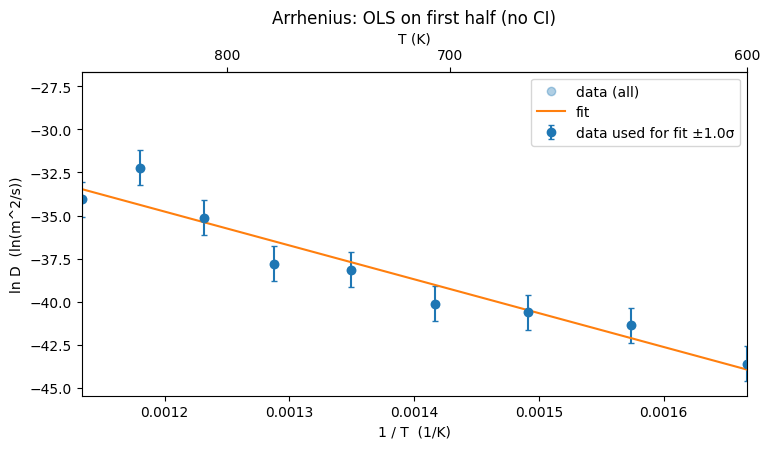

Fit mode: first_half, n_fit = 9, df = 7
Effective ln-noise σ ≈ 1.014  (ERRBAR_SIGMAS=1.0)
beta0 = ln D0 = -11.2183 ± 7.1545
beta1 = -Q/R  = -1.9629e+04 ± 5.1812e+03
D0_hat = 1.343e-05 ± 9.606e-05
Q_hat  = 163.2 ± 43.1  kJ/mol


In [ ]:
# --- Arrhenius (isolated) — linearized fit with adjustable noise, subset fit,
#     optional error bars and 95% CI band, plus top axis in T. ---
# This cell is self-contained: it DOES NOT reuse global T/lnD variables.
# All arrays are prefixed with _A to avoid collisions.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Import ticker

# ------------------------------ CONFIG (edit me) ------------------------------
R_A          = 8.31446261815324        # J/(mol·K)
Q_true_A     = 1.60e5                  # J/mol
D0_true_A    = 1.0e-5                  # m^2/s
N_T_A        = 18                      # number of temperature points
T_MIN_A      = 600.0                   # K
T_MAX_A      = 1200.0                   # K
RNG_SEED_A   = 7
SIGMA_LN_A   = 0.15                    # base SD of noise in ln D

NOISE_SCALE  = 10.0                    # 1.0 keeps base noise; >1 amplifies; <1 reduces
FIT_MODE     = "first_half"                   # "first_half" or "all"

# Plot toggles (like the simple OLS example)
SHOW_ERRORBARS = True                  # draw vertical error bars on the data
ERRBAR_ON      = "fit"                 # "fit", "all", "both", or "none"
ERRBAR_SIGMAS  = 1.0                   # errorbar size in units of ln-space SD (σ)
ERRBAR_CAPSIZE = 2.0
SHOW_CI_BAND   = False                  # show/hide the 95% confidence band (mean only)

ALPHA_CI       = 0.05                  # for 95% intervals (t critical)
# ------------------------------------------------------------------------------

# --------------------------- Simulate Arrhenius data --------------------------
rng_A = np.random.default_rng(RNG_SEED_A)
T_A = np.linspace(T_MIN_A, T_MAX_A, N_T_A)              # K
x_A = 1.0 / T_A                                         # 1/K

lnD_clean_A = np.log(D0_true_A) - Q_true_A / (R_A * T_A) #
eta_A       = rng_A.normal(0.0, SIGMA_LN_A, size=T_A.size)
lnD_A       = lnD_clean_A + NOISE_SCALE * eta_A         # scaled multiplicative noise in ln-space
y_A         = lnD_A

# ------------------------------ Choose fit subset -----------------------------
n_A = x_A.size
if FIT_MODE == "first_half":
    mask_fit_A = np.zeros(n_A, dtype=bool)
    mask_fit_A[: n_A//2] = True       # first half by index (change to x-sort if preferred)
elif FIT_MODE == "all":
    mask_fit_A = np.ones(n_A, dtype=bool)
else:
    raise ValueError("FIT_MODE must be 'first_half' or 'all'.")

x_fit_A, y_fit_A = x_A[mask_fit_A], y_A[mask_fit_A]

# ---------------------------------- OLS in ln-space ---------------------------
X_fit_A = np.column_stack([np.ones_like(x_fit_A), x_fit_A])
A_A     = X_fit_A.T @ X_fit_A
b_A     = X_fit_A.T @ y_fit_A
beta_A  = np.linalg.solve(A_A, b_A)                 # [beta0, beta1]
yhat_fit_A = X_fit_A @ beta_A
resid_fit_A = y_fit_A - yhat_fit_A

n_fit_A, p_A = X_fit_A.shape
nu_A = n_fit_A - p_A
SSE_A = float(np.sum(resid_fit_A**2))
sigma2_hat_A = SSE_A / nu_A
XtX_inv_A = np.linalg.inv(A_A)

# t-critical (SciPy if present; else ~1.96)
try:
    from scipy import stats
    tstar_A = stats.t.ppf(1 - ALPHA_CI/2, nu_A)
except Exception:
    tstar_A = 1.96

# --------------------------------- Plot domain --------------------------------
xx_A  = np.linspace(x_fit_A.min(), x_fit_A.max(), 250)
Xx_A  = np.column_stack([np.ones_like(xx_A), xx_A])
yfit_A = Xx_A @ beta_A

# Confidence band (mean-only), if enabled
if SHOW_CI_BAND:
    h_A = np.sum(Xx_A @ XtX_inv_A * Xx_A, axis=1)
    se_mean_A = np.sqrt(sigma2_hat_A * h_A)

# Effective ln-space noise SD (for error bars). Use sample SD of scaled noise:
sigma_ln_eff_A = float(np.std(NOISE_SCALE * eta_A, ddof=1))

# ------------------------------------ Plot ------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7.8, 4.6))

# ALL points
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"all", "both"}:
    ax.errorbar(x_A, y_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, alpha=0.35, label=f"data (all) ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_A, y_A, alpha=0.35, label="data (all)")

# FIT subset
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"fit", "both"}:
    ax.errorbar(x_fit_A, y_fit_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, label=f"data used for fit ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_fit_A, y_fit_A, label="data used for fit")

# Fit line
ax.plot(xx_A, yfit_A, label="fit")

# 95% CI (mean) if requested
if SHOW_CI_BAND:
    ax.plot(xx_A, yfit_A - tstar_A*se_mean_A, label="95% CI (mean)")
    ax.plot(xx_A, yfit_A + tstar_A*se_mean_A)

# Axes and title
ax.set_xlim(xx_A.min(), xx_A.max())
ax.set_xlabel("1 / T  (1/K)")
ax.set_ylabel("ln D  (ln(m^2/s))")
title_ci_A = "with 95% CI" if SHOW_CI_BAND else "no CI"
ax.set_title(f"Arrhenius: OLS on {FIT_MODE.replace('_',' ')} ({title_ci_A})")

# Top x-axis showing temperature: s = 1/T  <->  T = 1/s
# Use a custom formatter to display temperature on the secondary axis
def invT_formatter(x, pos):
    if x == 0:
        return 'inf'
    return f"{1.0/x:.0f}" # Format as integer temperature

secax_A = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x)) # Use identity function as we will control formatting

# Set the major tick locations on the secondary axis to be every 100 degrees
temp_ticks = np.arange(600, 1300, 100) # Generate temperatures from 600 to 1200 with step 100
inv_temp_ticks = 1.0 / temp_ticks # Convert temperatures to inverse temperatures
secax_A.set_xticks(inv_temp_ticks)

secax_A.xaxis.set_major_formatter(ticker.FuncFormatter(invT_formatter))
secax_A.set_xlabel("T (K)")

ax.legend()
fig.tight_layout()
plt.show()

# ------------------------- Parameter estimates & SEs --------------------------
beta0_A, beta1_A = beta_A
D0_hat_A = np.exp(beta0_A)     # delta method
Q_hat_A  = -beta1_A * R_A

se_beta_A = np.sqrt(np.diag(sigma2_hat_A * XtX_inv_A))
se_D0_A = D0_hat_A * se_beta_A[0]     # delta method
se_Q_A  = R_A * se_beta_A[1]


print(f"Fit mode: {FIT_MODE}, n_fit = {n_fit_A}, df = {nu_A}")
print(f"Effective ln-noise σ ≈ {sigma_ln_eff_A:.3f}  (ERRBAR_SIGMAS={ERRBAR_SIGMAS})")
print(f"beta0 = ln D0 = {beta0_A:.4f} ± {tstar_A*se_beta_A[0]:.4f}")
print(f"beta1 = -Q/R  = {beta1_A:.4e} ± {tstar_A*se_beta_A[1]:.4e}")
print(f"D0_hat = {D0_hat_A:.3e} ± {tstar_A*se_D0_A:.3e}")
print(f"Q_hat  = {Q_hat_A/1e3:.1f} ± {tstar_A*se_Q_A/1e3:.1f}  kJ/mol")

## Arrhenius Fit Numerical Results

Fit mode: first_half, n_fit = 9, df = 7

Effective ln-noise $\sigma \approx$ 1.014 (ERRBAR_SIGMAS=1.0)

$\beta_0 = \ln D_0 = $ -11.2183 $\pm$ 7.1545

$\beta_1 = -Q/R = $ -1.9629e+04 $\pm$ 5.1812e+03

$D_0^{\ast} = $ 1.343e-05 $\pm$ 9.606e-05

$Q^{\ast} = $ 163.2 $\pm$ 43.1 kJ/mol

# With Confidence Intervals

### We compute **95% t-intervals**, and show confidence bands in $\ln D$.


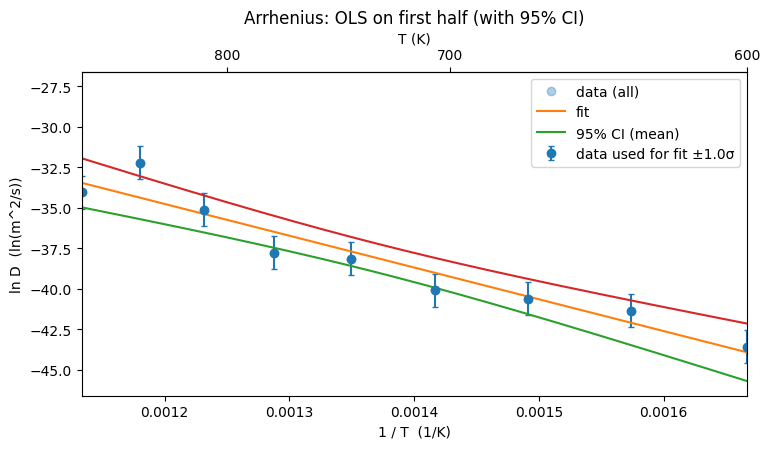

Fit mode: first_half, n_fit = 9, df = 7
Effective ln-noise σ ≈ 1.014  (ERRBAR_SIGMAS=1.0)
beta0 = ln D0 = -11.2183 ± 7.1545
beta1 = -Q/R  = -1.9629e+04 ± 5.1812e+03
D0_hat = 1.343e-05 ± 9.606e-05
Q_hat  = 163.2 ± 43.1  kJ/mol


In [ ]:
# --- Arrhenius (isolated) — linearized fit with adjustable noise, subset fit,
#     optional error bars and 95% CI band, plus top axis in T. ---
# This cell is self-contained: it DOES NOT reuse global T/lnD variables.
# All arrays are prefixed with _A to avoid collisions.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Import ticker

# ------------------------------ CONFIG (edit me) ------------------------------
R_A          = 8.31446261815324        # J/(mol·K)
Q_true_A     = 1.60e5                  # J/mol
D0_true_A    = 1.0e-5                  # m^2/s
N_T_A        = 18                      # number of temperature points
T_MIN_A      = 600.0                   # K
T_MAX_A      = 1200.0                   # K
RNG_SEED_A   = 7
SIGMA_LN_A   = 0.15                    # base SD of noise in ln D

NOISE_SCALE  = 10.0                    # 1.0 keeps base noise; >1 amplifies; <1 reduces
FIT_MODE     = "first_half"                   # "first_half" or "all"

# Plot toggles (like the simple OLS example)
SHOW_ERRORBARS = True                  # draw vertical error bars on the data
ERRBAR_ON      = "fit"                 # "fit", "all", "both", or "none"
ERRBAR_SIGMAS  = 1.0                   # errorbar size in units of ln-space SD (σ)
ERRBAR_CAPSIZE = 2.0
SHOW_CI_BAND   = True                  # show/hide the 95% confidence band (mean only)

ALPHA_CI       = 0.05                  # for 95% intervals (t critical)
# ------------------------------------------------------------------------------

# --------------------------- Simulate Arrhenius data --------------------------
rng_A = np.random.default_rng(RNG_SEED_A)
T_A = np.linspace(T_MIN_A, T_MAX_A, N_T_A)              # K
x_A = 1.0 / T_A                                         # 1/K

lnD_clean_A = np.log(D0_true_A) - Q_true_A / (R_A * T_A) #
eta_A       = rng_A.normal(0.0, SIGMA_LN_A, size=T_A.size)
lnD_A       = lnD_clean_A + NOISE_SCALE * eta_A         # scaled multiplicative noise in ln-space
y_A         = lnD_A

# ------------------------------ Choose fit subset -----------------------------
n_A = x_A.size
if FIT_MODE == "first_half":
    mask_fit_A = np.zeros(n_A, dtype=bool)
    mask_fit_A[: n_A//2] = True       # first half by index (change to x-sort if preferred)
elif FIT_MODE == "all":
    mask_fit_A = np.ones(n_A, dtype=bool)
else:
    raise ValueError("FIT_MODE must be 'first_half' or 'all'.")

x_fit_A, y_fit_A = x_A[mask_fit_A], y_A[mask_fit_A]

# ---------------------------------- OLS in ln-space ---------------------------
X_fit_A = np.column_stack([np.ones_like(x_fit_A), x_fit_A])
A_A     = X_fit_A.T @ X_fit_A
b_A     = X_fit_A.T @ y_fit_A
beta_A  = np.linalg.solve(A_A, b_A)                 # [beta0, beta1]
yhat_fit_A = X_fit_A @ beta_A
resid_fit_A = y_fit_A - yhat_fit_A

n_fit_A, p_A = X_fit_A.shape
nu_A = n_fit_A - p_A
SSE_A = float(np.sum(resid_fit_A**2))
sigma2_hat_A = SSE_A / nu_A
XtX_inv_A = np.linalg.inv(A_A)

# t-critical (SciPy if present; else ~1.96)
try:
    from scipy import stats
    tstar_A = stats.t.ppf(1 - ALPHA_CI/2, nu_A)
except Exception:
    tstar_A = 1.96

# --------------------------------- Plot domain --------------------------------
xx_A  = np.linspace(x_fit_A.min(), x_fit_A.max(), 250)
Xx_A  = np.column_stack([np.ones_like(xx_A), xx_A])
yfit_A = Xx_A @ beta_A

# Confidence band (mean-only), if enabled
if SHOW_CI_BAND:
    h_A = np.sum(Xx_A @ XtX_inv_A * Xx_A, axis=1)
    se_mean_A = np.sqrt(sigma2_hat_A * h_A)

# Effective ln-space noise SD (for error bars). Use sample SD of scaled noise:
sigma_ln_eff_A = float(np.std(NOISE_SCALE * eta_A, ddof=1))

# ------------------------------------ Plot ------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7.8, 4.6))

# ALL points
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"all", "both"}:
    ax.errorbar(x_A, y_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, alpha=0.35, label=f"data (all) ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_A, y_A, alpha=0.35, label="data (all)")

# FIT subset
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"fit", "both"}:
    ax.errorbar(x_fit_A, y_fit_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, label=f"data used for fit ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_fit_A, y_fit_A, label="data used for fit")

# Fit line
ax.plot(xx_A, yfit_A, label="fit")

# 95% CI (mean) if requested
if SHOW_CI_BAND:
    ax.plot(xx_A, yfit_A - tstar_A*se_mean_A, label="95% CI (mean)")
    ax.plot(xx_A, yfit_A + tstar_A*se_mean_A)

# Axes and title
ax.set_xlim(xx_A.min(), xx_A.max())
ax.set_xlabel("1 / T  (1/K)")
ax.set_ylabel("ln D  (ln(m^2/s))")
title_ci_A = "with 95% CI" if SHOW_CI_BAND else "no CI"
ax.set_title(f"Arrhenius: OLS on {FIT_MODE.replace('_',' ')} ({title_ci_A})")

# Top x-axis showing temperature: s = 1/T  <->  T = 1/s
# Use a custom formatter to display temperature on the secondary axis
def invT_formatter(x, pos):
    if x == 0:
        return 'inf'
    return f"{1.0/x:.0f}" # Format as integer temperature

secax_A = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x)) # Use identity function as we will control formatting

# Set the major tick locations on the secondary axis to be every 100 degrees
temp_ticks = np.arange(600, 1300, 100) # Generate temperatures from 600 to 1200 with step 100
inv_temp_ticks = 1.0 / temp_ticks # Convert temperatures to inverse temperatures
secax_A.set_xticks(inv_temp_ticks)

secax_A.xaxis.set_major_formatter(ticker.FuncFormatter(invT_formatter))
secax_A.set_xlabel("T (K)")

ax.legend()
fig.tight_layout()
plt.show()

# ------------------------- Parameter estimates & SEs --------------------------
beta0_A, beta1_A = beta_A
D0_hat_A = np.exp(beta0_A)     # delta method
Q_hat_A  = -beta1_A * R_A

se_beta_A = np.sqrt(np.diag(sigma2_hat_A * XtX_inv_A))
se_D0_A = D0_hat_A * se_beta_A[0]     # delta method
se_Q_A  = R_A * se_beta_A[1]


print(f"Fit mode: {FIT_MODE}, n_fit = {n_fit_A}, df = {nu_A}")
print(f"Effective ln-noise σ ≈ {sigma_ln_eff_A:.3f}  (ERRBAR_SIGMAS={ERRBAR_SIGMAS})")
print(f"beta0 = ln D0 = {beta0_A:.4f} ± {tstar_A*se_beta_A[0]:.4f}")
print(f"beta1 = -Q/R  = {beta1_A:.4e} ± {tstar_A*se_beta_A[1]:.4e}")
print(f"D0_hat = {D0_hat_A:.3e} ± {tstar_A*se_D0_A:.3e}")
print(f"Q_hat  = {Q_hat_A/1e3:.1f} ± {tstar_A*se_Q_A/1e3:.1f}  kJ/mol")

# Confidence Intervals Derived from Standard Error

The confidence intervals for the fitted line at a given point $x_i$ are calculated as:

$$
\hat{y}_i \pm t^{\ast} \cdot \mathrm{SE}(\hat{y}_i)
$$

where $\hat{y}_i$ is the predicted value at $x_i$, $t^{\ast}$ is the critical value from the t-distribution, and $\mathrm{SE}(\hat{y}_i)$ is the standard error of the predicted mean at $x_i$.

The standard error of the predicted mean at $x_i$ is given by:

$$
\mathrm{SE}(\hat{y}_i) = \sqrt{\widehat{\sigma}^2 \left( \frac{1}{n_{\text{fit}}} + \frac{(x_i - \bar{x}_{\text{fit}})^2}{\sum_{j=1}^{n_{\text{fit}}} (x_j - \bar{x}_{\text{fit}})^2} \right)}
$$

where
- $\widehat{\sigma}^2$ is the estimated variance of the errors,
- $n_{\text{fit}}$ is the number of data points used for fitting, and
- $\bar{x}_{\text{fit}}$ is the mean of the $x$ values used for fitting.

The value of `tstar_A` is **not** calculated point-wise. It is a single value determined by the desired confidence level (e.g., 95%) and the degrees of freedom of the fit:

 $\nu = n_{\text{fit}} - p$, where $p$ is the number of parameters, which is 2 for a linear fit.

 This single $t^{\ast}$ value is then used to calculate the confidence interval at each point $x_i$. The width of the confidence band varies with $x_i$ because the standard error of the predicted mean, $\mathrm{SE}(\hat{y}_i)$, depends on $x_i$.

# Expanded Temperature Range Plot

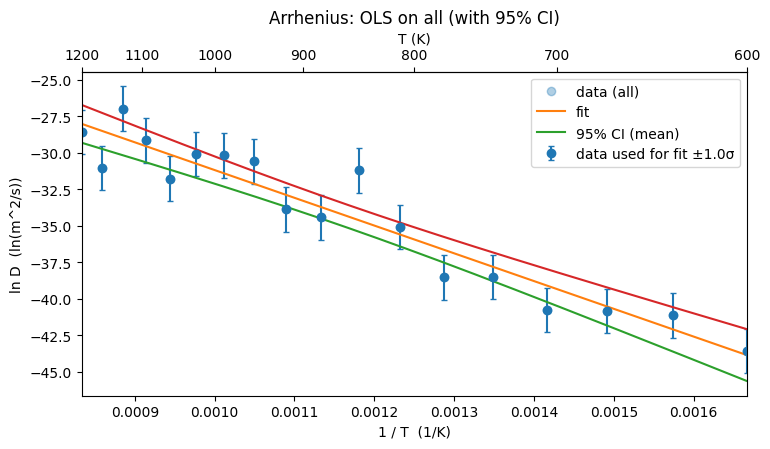

Fit mode: all, n_fit = 18, df = 16
Effective ln-noise σ ≈ 1.521  (ERRBAR_SIGMAS=1.0)
beta0 = ln D0 = -12.2063 ± 3.7347
beta1 = -Q/R  = -1.8984e+04 ± 3.1457e+03
D0_hat = 4.999e-06 ± 1.867e-05
Q_hat  = 157.8 ± 26.2  kJ/mol


In [ ]:
# --- Arrhenius (isolated) — linearized fit with adjustable noise, subset fit,
#     optional error bars and 95% CI band, plus top axis in T. ---
# This cell is self-contained: it DOES NOT reuse global T/lnD variables.
# All arrays are prefixed with _A to avoid collisions.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Import ticker

# ------------------------------ CONFIG (edit me) ------------------------------
R_A          = 8.31446261815324        # J/(mol·K)
Q_true_A     = 1.60e5                  # J/mol
D0_true_A    = 1.0e-5                  # m^2/s
N_T_A        = 18                      # number of temperature points
T_MIN_A      = 600.0                   # K
T_MAX_A      = 1200.0                   # K
RNG_SEED_A   = 7
SIGMA_LN_A   = 0.15                    # base SD of noise in ln D

NOISE_SCALE  = 15.0                    # 1.0 keeps base noise; >1 amplifies; <1 reduces
FIT_MODE     = "all"                   # "first_half" or "all"

# Plot toggles (like the simple OLS example)
SHOW_ERRORBARS = True                  # draw vertical error bars on the data
ERRBAR_ON      = "fit"                 # "fit", "all", "both", or "none"
ERRBAR_SIGMAS  = 1.0                   # errorbar size in units of ln-space SD (σ)
ERRBAR_CAPSIZE = 2.0
SHOW_CI_BAND   = True                  # show/hide the 95% confidence band (mean only)

ALPHA_CI       = 0.05                  # for 95% intervals (t critical)
# ------------------------------------------------------------------------------

# --------------------------- Simulate Arrhenius data --------------------------
rng_A = np.random.default_rng(RNG_SEED_A)
T_A = np.linspace(T_MIN_A, T_MAX_A, N_T_A)              # K
x_A = 1.0 / T_A                                         # 1/K

lnD_clean_A = np.log(D0_true_A) - Q_true_A / (R_A * T_A) #
eta_A       = rng_A.normal(0.0, SIGMA_LN_A, size=T_A.size)
lnD_A       = lnD_clean_A + NOISE_SCALE * eta_A         # scaled multiplicative noise in ln-space
y_A         = lnD_A

# ------------------------------ Choose fit subset -----------------------------
n_A = x_A.size
if FIT_MODE == "first_half":
    mask_fit_A = np.zeros(n_A, dtype=bool)
    mask_fit_A[: n_A//2] = True       # first half by index (change to x-sort if preferred)
elif FIT_MODE == "all":
    mask_fit_A = np.ones(n_A, dtype=bool)
else:
    raise ValueError("FIT_MODE must be 'first_half' or 'all'.")

x_fit_A, y_fit_A = x_A[mask_fit_A], y_A[mask_fit_A]

# ---------------------------------- OLS in ln-space ---------------------------
X_fit_A = np.column_stack([np.ones_like(x_fit_A), x_fit_A])
A_A     = X_fit_A.T @ X_fit_A
b_A     = X_fit_A.T @ y_fit_A
beta_A  = np.linalg.solve(A_A, b_A)                 # [beta0, beta1]
yhat_fit_A = X_fit_A @ beta_A
resid_fit_A = y_fit_A - yhat_fit_A

n_fit_A, p_A = X_fit_A.shape
nu_A = n_fit_A - p_A
SSE_A = float(np.sum(resid_fit_A**2))
sigma2_hat_A = SSE_A / nu_A
XtX_inv_A = np.linalg.inv(A_A)

# t-critical (SciPy if present; else ~1.96)
try:
    from scipy import stats
    tstar_A = stats.t.ppf(1 - ALPHA_CI/2, nu_A)
except Exception:
    tstar_A = 1.96

# --------------------------------- Plot domain --------------------------------
xx_A  = np.linspace(x_fit_A.min(), x_fit_A.max(), 250)
Xx_A  = np.column_stack([np.ones_like(xx_A), xx_A])
yfit_A = Xx_A @ beta_A

# Confidence band (mean-only), if enabled
if SHOW_CI_BAND:
    h_A = np.sum(Xx_A @ XtX_inv_A * Xx_A, axis=1)
    se_mean_A = np.sqrt(sigma2_hat_A * h_A)

# Effective ln-space noise SD (for error bars). Use sample SD of scaled noise:
sigma_ln_eff_A = float(np.std(NOISE_SCALE * eta_A, ddof=1))

# ------------------------------------ Plot ------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7.8, 4.6))

# ALL points
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"all", "both"}:
    ax.errorbar(x_A, y_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, alpha=0.35, label=f"data (all) ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_A, y_A, alpha=0.35, label="data (all)")

# FIT subset
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"fit", "both"}:
    ax.errorbar(x_fit_A, y_fit_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, label=f"data used for fit ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_fit_A, y_fit_A, label="data used for fit")

# Fit line
ax.plot(xx_A, yfit_A, label="fit")

# 95% CI (mean) if requested
if SHOW_CI_BAND:
    ax.plot(xx_A, yfit_A - tstar_A*se_mean_A, label="95% CI (mean)")
    ax.plot(xx_A, yfit_A + tstar_A*se_mean_A)

# Axes and title
ax.set_xlim(xx_A.min(), xx_A.max())
ax.set_xlabel("1 / T  (1/K)")
ax.set_ylabel("ln D  (ln(m^2/s))")
title_ci_A = "with 95% CI" if SHOW_CI_BAND else "no CI"
ax.set_title(f"Arrhenius: OLS on {FIT_MODE.replace('_',' ')} ({title_ci_A})")

# Top x-axis showing temperature: s = 1/T  <->  T = 1/s
# Use a custom formatter to display temperature on the secondary axis
def invT_formatter(x, pos):
    if x == 0:
        return 'inf'
    return f"{1.0/x:.0f}" # Format as integer temperature

secax_A = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x)) # Use identity function as we will control formatting

# Set the major tick locations on the secondary axis to be every 100 degrees
temp_ticks = np.arange(600, 1300, 100) # Generate temperatures from 600 to 1200 with step 100
inv_temp_ticks = 1.0 / temp_ticks # Convert temperatures to inverse temperatures
secax_A.set_xticks(inv_temp_ticks)

secax_A.xaxis.set_major_formatter(ticker.FuncFormatter(invT_formatter))
secax_A.set_xlabel("T (K)")

ax.legend()
fig.tight_layout()
plt.show()

# ------------------------- Parameter estimates & SEs --------------------------
beta0_A, beta1_A = beta_A
D0_hat_A = np.exp(beta0_A)     # delta method
Q_hat_A  = -beta1_A * R_A

se_beta_A = np.sqrt(np.diag(sigma2_hat_A * XtX_inv_A))
se_D0_A = D0_hat_A * se_beta_A[0]     # delta method
se_Q_A  = R_A * se_beta_A[1]


print(f"Fit mode: {FIT_MODE}, n_fit = {n_fit_A}, df = {nu_A}")
print(f"Effective ln-noise σ ≈ {sigma_ln_eff_A:.3f}  (ERRBAR_SIGMAS={ERRBAR_SIGMAS})")
print(f"beta0 = ln D0 = {beta0_A:.4f} ± {tstar_A*se_beta_A[0]:.4f}")
print(f"beta1 = -Q/R  = {beta1_A:.4e} ± {tstar_A*se_beta_A[1]:.4e}")
print(f"D0_hat = {D0_hat_A:.3e} ± {tstar_A*se_D0_A:.3e}")
print(f"Q_hat  = {Q_hat_A/1e3:.1f} ± {tstar_A*se_Q_A/1e3:.1f}  kJ/mol")

# Reduced Uncertainty on D(T) Plot

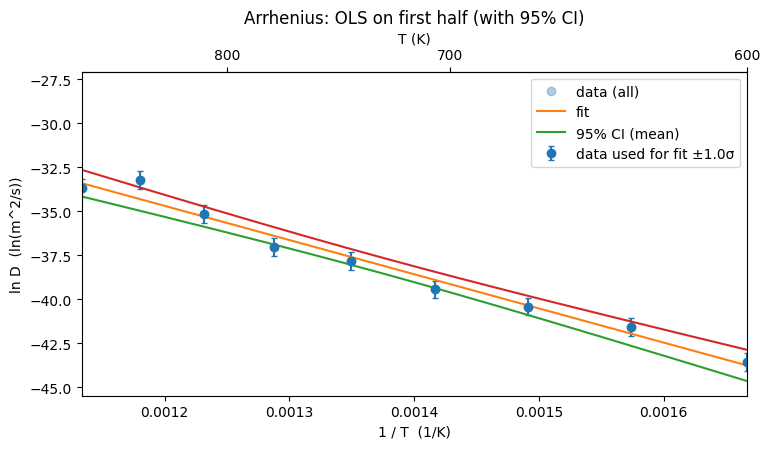

Fit mode: first_half, n_fit = 9, df = 7
Effective ln-noise σ ≈ 0.507  (ERRBAR_SIGMAS=1.0)
beta0 = ln D0 = -11.3656 ± 3.5773
beta1 = -Q/R  = -1.9436e+04 ± 2.5906e+03
D0_hat = 1.159e-05 ± 4.145e-05
Q_hat  = 161.6 ± 21.5  kJ/mol


In [ ]:
# --- Arrhenius (isolated) — linearized fit with adjustable noise, subset fit,
#     optional error bars and 95% CI band, plus top axis in T. ---
# This cell is self-contained: it DOES NOT reuse global T/lnD variables.
# All arrays are prefixed with _A to avoid collisions.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Import ticker

# ------------------------------ CONFIG (edit me) ------------------------------
R_A          = 8.31446261815324        # J/(mol·K)
Q_true_A     = 1.60e5                  # J/mol
D0_true_A    = 1.0e-5                  # m^2/s
N_T_A        = 18                      # number of temperature points
T_MIN_A      = 600.0                   # K
T_MAX_A      = 1200.0                   # K
RNG_SEED_A   = 7
SIGMA_LN_A   = 0.15                    # base SD of noise in ln D

NOISE_SCALE  = 5                    # 1.0 keeps base noise; >1 amplifies; <1 reduces
FIT_MODE     = "first_half"                   # "first_half" or "all"

# Plot toggles (like the simple OLS example)
SHOW_ERRORBARS = True                  # draw vertical error bars on the data
ERRBAR_ON      = "fit"                 # "fit", "all", "both", or "none"
ERRBAR_SIGMAS  = 1.0                   # errorbar size in units of ln-space SD (σ)
ERRBAR_CAPSIZE = 2.0
SHOW_CI_BAND   = True                  # show/hide the 95% confidence band (mean only)

ALPHA_CI       = 0.05                  # for 95% intervals (t critical)
# ------------------------------------------------------------------------------

# --------------------------- Simulate Arrhenius data --------------------------
rng_A = np.random.default_rng(RNG_SEED_A)
T_A = np.linspace(T_MIN_A, T_MAX_A, N_T_A)              # K
x_A = 1.0 / T_A                                         # 1/K

lnD_clean_A = np.log(D0_true_A) - Q_true_A / (R_A * T_A) #
eta_A       = rng_A.normal(0.0, SIGMA_LN_A, size=T_A.size)
lnD_A       = lnD_clean_A + NOISE_SCALE * eta_A         # scaled multiplicative noise in ln-space
y_A         = lnD_A

# ------------------------------ Choose fit subset -----------------------------
n_A = x_A.size
if FIT_MODE == "first_half":
    mask_fit_A = np.zeros(n_A, dtype=bool)
    mask_fit_A[: n_A//2] = True       # first half by index (change to x-sort if preferred)
elif FIT_MODE == "all":
    mask_fit_A = np.ones(n_A, dtype=bool)
else:
    raise ValueError("FIT_MODE must be 'first_half' or 'all'.")

x_fit_A, y_fit_A = x_A[mask_fit_A], y_A[mask_fit_A]

# ---------------------------------- OLS in ln-space ---------------------------
X_fit_A = np.column_stack([np.ones_like(x_fit_A), x_fit_A])
A_A     = X_fit_A.T @ X_fit_A
b_A     = X_fit_A.T @ y_fit_A
beta_A  = np.linalg.solve(A_A, b_A)                 # [beta0, beta1]
yhat_fit_A = X_fit_A @ beta_A
resid_fit_A = y_fit_A - yhat_fit_A

n_fit_A, p_A = X_fit_A.shape
nu_A = n_fit_A - p_A
SSE_A = float(np.sum(resid_fit_A**2))
sigma2_hat_A = SSE_A / nu_A
XtX_inv_A = np.linalg.inv(A_A)

# t-critical (SciPy if present; else ~1.96)
try:
    from scipy import stats
    tstar_A = stats.t.ppf(1 - ALPHA_CI/2, nu_A)
except Exception:
    tstar_A = 1.96

# --------------------------------- Plot domain --------------------------------
xx_A  = np.linspace(x_fit_A.min(), x_fit_A.max(), 250)
Xx_A  = np.column_stack([np.ones_like(xx_A), xx_A])
yfit_A = Xx_A @ beta_A

# Confidence band (mean-only), if enabled
if SHOW_CI_BAND:
    h_A = np.sum(Xx_A @ XtX_inv_A * Xx_A, axis=1)
    se_mean_A = np.sqrt(sigma2_hat_A * h_A)

# Effective ln-space noise SD (for error bars). Use sample SD of scaled noise:
sigma_ln_eff_A = float(np.std(NOISE_SCALE * eta_A, ddof=1))

# ------------------------------------ Plot ------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7.8, 4.6))

# ALL points
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"all", "both"}:
    ax.errorbar(x_A, y_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, alpha=0.35, label=f"data (all) ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_A, y_A, alpha=0.35, label="data (all)")

# FIT subset
if SHOW_ERRORBARS and ERRBAR_ON.lower() in {"fit", "both"}:
    ax.errorbar(x_fit_A, y_fit_A, yerr=ERRBAR_SIGMAS*sigma_ln_eff_A, fmt='o',
                capsize=ERRBAR_CAPSIZE, label=f"data used for fit ±{ERRBAR_SIGMAS}σ")
else:
    ax.scatter(x_fit_A, y_fit_A, label="data used for fit")

# Fit line
ax.plot(xx_A, yfit_A, label="fit")

# 95% CI (mean) if requested
if SHOW_CI_BAND:
    ax.plot(xx_A, yfit_A - tstar_A*se_mean_A, label="95% CI (mean)")
    ax.plot(xx_A, yfit_A + tstar_A*se_mean_A)

# Axes and title
ax.set_xlim(xx_A.min(), xx_A.max())
ax.set_xlabel("1 / T  (1/K)")
ax.set_ylabel("ln D  (ln(m^2/s))")
title_ci_A = "with 95% CI" if SHOW_CI_BAND else "no CI"
ax.set_title(f"Arrhenius: OLS on {FIT_MODE.replace('_',' ')} ({title_ci_A})")

# Top x-axis showing temperature: s = 1/T  <->  T = 1/s
# Use a custom formatter to display temperature on the secondary axis
def invT_formatter(x, pos):
    if x == 0:
        return 'inf'
    return f"{1.0/x:.0f}" # Format as integer temperature

secax_A = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x)) # Use identity function as we will control formatting

# Set the major tick locations on the secondary axis to be every 100 degrees
temp_ticks = np.arange(600, 1300, 100) # Generate temperatures from 600 to 1200 with step 100
inv_temp_ticks = 1.0 / temp_ticks # Convert temperatures to inverse temperatures
secax_A.set_xticks(inv_temp_ticks)

secax_A.xaxis.set_major_formatter(ticker.FuncFormatter(invT_formatter))
secax_A.set_xlabel("T (K)")

ax.legend()
fig.tight_layout()
plt.show()

# ------------------------- Parameter estimates & SEs --------------------------
beta0_A, beta1_A = beta_A
D0_hat_A = np.exp(beta0_A)     # delta method
Q_hat_A  = -beta1_A * R_A

se_beta_A = np.sqrt(np.diag(sigma2_hat_A * XtX_inv_A))
se_D0_A = D0_hat_A * se_beta_A[0]     # delta method
se_Q_A  = R_A * se_beta_A[1]


print(f"Fit mode: {FIT_MODE}, n_fit = {n_fit_A}, df = {nu_A}")
print(f"Effective ln-noise σ ≈ {sigma_ln_eff_A:.3f}  (ERRBAR_SIGMAS={ERRBAR_SIGMAS})")
print(f"beta0 = ln D0 = {beta0_A:.4f} ± {tstar_A*se_beta_A[0]:.4f}")
print(f"beta1 = -Q/R  = {beta1_A:.4e} ± {tstar_A*se_beta_A[1]:.4e}")
print(f"D0_hat = {D0_hat_A:.3e} ± {tstar_A*se_D0_A:.3e}")
print(f"Q_hat  = {Q_hat_A/1e3:.1f} ± {tstar_A*se_Q_A/1e3:.1f}  kJ/mol")

## Parameter relationships and what the printout means

**Linearized model and design.**  
Define $x_i = 1/T_i$ and $y_i = \ln D_i$. We fit the straight line
$$
y_i \;=\; \beta_0 + \beta_1 x_i + \eta_i,\qquad \eta_i \sim \mathcal{N}(0,\sigma_{\ln}^2).
$$
With design matrix $X=[\mathbf{1}\ \ \mathbf{x}]$ and response $\mathbf{y}$, the OLS estimator is
$$
\hat{\boldsymbol{\beta}} \;=\;
\begin{bmatrix}\beta_0^{\ast}\\ \beta_1^{\ast}\end{bmatrix}
\;=\; (X^{\top}X)^{-1}X^{\top}\mathbf{y}.
$$

**Noise, degrees of freedom, and covariance.**  
Residual sum of squares:
$$
\mathrm{SSE} \;=\; \sum_{i=1}^{n_{\text{fit}}}\!\big(y_i - \beta_0^{\ast}-\beta_1^{\ast}x_i\big)^2.
$$
Degrees of freedom: $\nu = n_{\text{fit}} - 2$.  
Variance estimate:
$$
\widehat{\sigma}^{2} \;=\; \frac{\mathrm{SSE}}{\nu}.
$$
Coefficient covariance and standard errors (SEs):
$$
\mathrm{Cov}\!\big(\hat{\boldsymbol{\beta}}\big) \;=\; \widehat{\sigma}^{2}\,(X^{\top}X)^{-1},\qquad
\mathrm{SE}(\beta_0^{\ast})=\sqrt{\big[\mathrm{Cov}(\hat{\boldsymbol{\beta}})\big]_{00}},\quad
\mathrm{SE}(\beta_1^{\ast})=\sqrt{\big[\mathrm{Cov}(\hat{\boldsymbol{\beta}})\big]_{11}}.
$$

**Mapping to physical Arrhenius parameters.**  
From $D(T)=D_0\exp\!\big(-Q/(RT)\big)$ we identify
$$
\beta_0 = \ln D_0,\qquad \beta_1 = -\frac{Q}{R}.
$$
Point estimates reported by the code:
$$
D_0^{\ast}=\exp(\beta_0^{\ast}),\qquad Q^{\ast}=-\,R\,\beta_1^{\ast}.
$$

**SEs for $D_0$ and $Q$ (delta method used in the code).**  
$$
\mathrm{SE}(D_0^{\ast}) \;\approx\; \left|\frac{\partial\,\exp(\beta_0)}{\partial\beta_0}\right|_{\beta_0=\beta_0^{\ast}}
\mathrm{SE}(\beta_0^{\ast})
\;=\; D_0^{\ast}\,\mathrm{SE}(\beta_0^{\ast}),
$$
$$
\mathrm{SE}(Q^{\ast}) \;=\; \left| -R \right|\,\mathrm{SE}(\beta_1^{\ast})
\;=\; R\,\mathrm{SE}(\beta_1^{\ast}).
$$

**Printed 95% confidence intervals (CIs).**  
With $t^{\ast}=t_{1-\alpha/2,\ \nu}$ (the code uses $\alpha=0.05$):
$$
\beta_j^{\ast} \;\pm\; t^{\ast}\,\mathrm{SE}(\beta_j^{\ast}),\quad j\in\{0,1\},
$$
$$
D_0^{\ast} \;\pm\; t^{\ast}\,\mathrm{SE}(D_0^{\ast}),\qquad
Q^{\ast} \;\pm\; t^{\ast}\,\mathrm{SE}(Q^{\ast}).
$$
*(Alternative for $D_0$: form a CI for $\beta_0=\ln D_0$ in log space and then exponentiate to get an asymmetric CI in original units.)*

**Summary of the variables printed by the code.**
- `beta0 = ln D0` $\leftrightarrow$ $\beta_0^{\ast}$; `beta1 = -Q/R` $\leftrightarrow$ $\beta_1^{\ast}$.
- `D0_hat = exp(beta0)` $\leftrightarrow$ $D_0^{\ast}$; `Q_hat = -beta1 * R` $\leftrightarrow$ $Q^{\ast}$.
- `se_beta[0], se_beta[1]` $\leftrightarrow$ $\mathrm{SE}(\beta_0^{\ast})$ and $\mathrm{SE}(\beta_1^{\ast})$.
- `se_D0 = D0_hat * se_beta[0]` (delta method for $D_0$).
- `se_Q  = R * se_beta[1]` (SE for $Q$).  
Each estimate is printed with its $\pm\,t^{\ast}\times\mathrm{SE}$ 95% CI.


# When to Linearize vs Fit in the Original Space

**Linearization** is attractive because it lets you use ordinary least squares on a straight line:
- Arrhenius: $$D(T) = D_0 \exp\!\left(-\frac{Q}{RT}\right) \Rightarrow \ln D = \ln D_0 - \frac{Q}{R}\,\frac{1}{T}.$$
- Stefan–Boltzmann: $$P = C\,T^4 \Rightarrow \ln P = \ln C + 4 \ln T.$$
- Power law: $$y = c\,x^k \Rightarrow \ln y = \ln c + k \ln x.$$

**But transforms change the noise model.** Prefer to linearize when:
- Errors are **multiplicative** in the original space (log-normal), so the transform yields roughly **constant variance**.
- Residual plots in the transformed space look unstructured and homoscedastic.

Prefer **original-space nonlinear least squares (NLS)** when:
- Errors are **additive** with constant variance in the original space.
- You need CIs or predictions **in original units** without back-transform bias.

**Practical approach:** Try both. Inspect residuals in the fitting space. Use WLS/NLS if variance clearly depends on the predictor.




---


# Part 3 — Stefan–Boltzmann: Log–Log Linearization vs Original-Space Fit

Law:

$$\frac{P}{A} = E = \epsilon\,\sigma_{\mathrm{SB}}\,T^4 \equiv b\,T^4$$ with $$b=\epsilon \sigma_{\mathrm{SB}}.$$

<br>

Log–log:
$$
\ln E = \ln b + 4 \ln T.
$$




## Stefan Boltzmann Fits: OLS

Log–log OLS (ln E vs ln T):
Intercept (ln b): -26.4162  => b_hat ≈ 3.370e-12,   b_true = 5.103e-12
Slope (should be ~4): 4.0650

Original-space NLS on E(T) = b T^4:
b_hat ≈ 5.374e-12 ± 2.062e-13  (approx 95% CI)


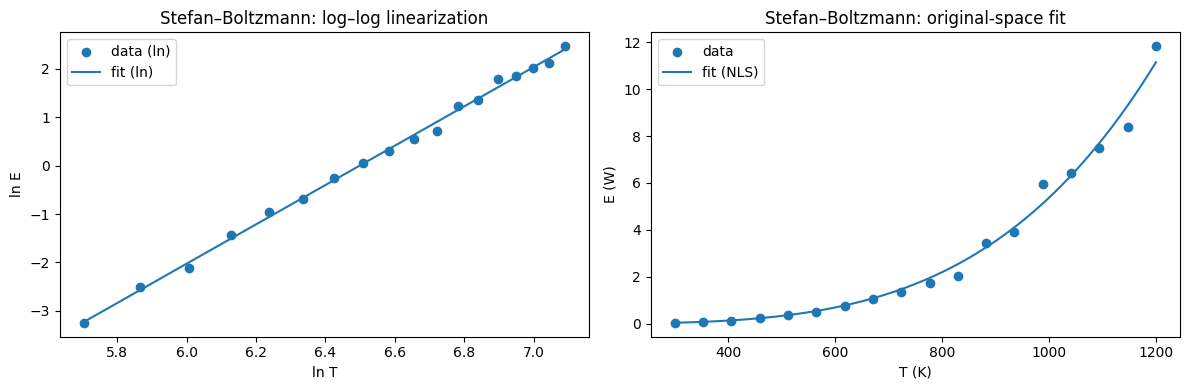

In [2]:
# OLS Fit no error bars

import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.optimize import curve_fit
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# -------------------- CONFIG (edit me) --------------------
sigma_SB = 5.670374419e-8   # W/(m^2 K^4)
epsilon_true = 0.9
A_true = 1.0e-4             # m^2
b_true = epsilon_true * sigma_SB * A_true

rng = np.random.default_rng(9)
T = np.linspace(300.0, 1200.0, 18)   # Kelvin
sigma_lnE = 0.08                     # multiplicative noise level
# ----------------------------------------------------------

E_clean = b_true * T**4
E = E_clean * np.exp(rng.normal(0.0, sigma_lnE, size=T.size))

# Log–log OLS
x = np.log(T)
y = np.log(E)
X = np.column_stack([np.ones_like(x), x])
beta = np.linalg.lstsq(X, y, rcond=None)[0]
beta0, beta1 = beta  # expect beta1 ~ 4

xx = np.linspace(x.min(), x.max(), 200)
Xx = np.column_stack([np.ones_like(xx), xx])
yhat = Xx @ beta

print("Log–log OLS (ln E vs ln T):")
print(f"Intercept (ln b): {beta0:.4f}  => b_hat ≈ {np.exp(beta0):.3e},   b_true = {b_true:.3e}")
print(f"Slope (should be ~4): {beta1:.4f}")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Log–log OLS
axes[0].scatter(x, y, label="data (ln)")
axes[0].plot(xx, yhat, label="fit (ln)")
axes[0].set_xlabel("ln T")
axes[0].set_ylabel("ln E")
axes[0].set_title("Stefan–Boltzmann: log–log linearization")
axes[0].legend()

# Original-space NLS comparison
if SCIPY_OK:
    def E_model(T, b):
        return b * T**4
    popt, pcov = curve_fit(E_model, T, E, p0=(b_true * 0.8,))
    b_hat = popt[0]
    se_b = np.sqrt(np.diag(pcov))[0]
    print("\nOriginal-space NLS on E(T) = b T^4:")
    print(f"b_hat ≈ {b_hat:.3e} ± {1.96*se_b:.3e}  (approx 95% CI)")

    # Plot 2: Original-space NLS
    TT = np.linspace(T.min(), T.max(), 200)
    axes[1].scatter(T, E, label="data")
    axes[1].plot(TT, E_model(TT, b_hat), label="fit (NLS)")
    axes[1].set_xlabel("T (K)")
    axes[1].set_ylabel("E (W)")
    axes[1].set_title("Stefan–Boltzmann: original-space fit")
    axes[1].legend()

    fig.tight_layout()
    plt.show()
else:
    print("SciPy not available; skipping original-space fit for E(T).")

## Stefan-Boltzmann OLS showing error bars in T

Log–log OLS (ln E vs ln T_obs):
Intercept (ln b): -26.0011  => b_hat ≈ 5.103e-12,   b_true = 5.103e-12
Slope (should be ~4): 4.0000

Original-space NLS on E(T_obs) = b T_obs^4:
b_hat ≈ 5.103e-12 ± 0.000e+00  (approx 95% CI)


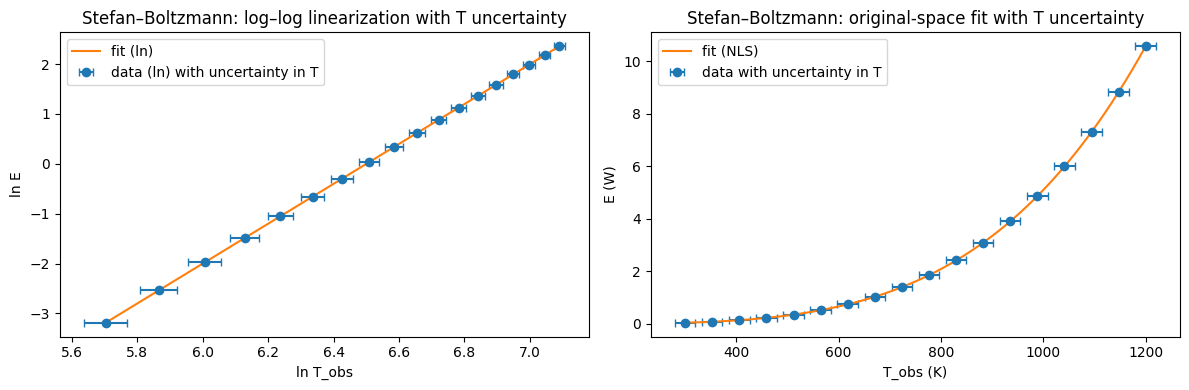

In [4]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.optimize import curve_fit
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# -------------------- CONFIG (edit me) --------------------
sigma_SB = 5.670374419e-8   # W/(m^2 K^4)
epsilon_true = 0.9
A_true = 1.0e-4             # m^2
b_true = epsilon_true * sigma_SB * A_true

rng = np.random.default_rng(9)
T_clean = np.linspace(300.0, 1200.0, 18)   # Kelvin (True temperatures)
sigma_T = 20.0 # Standard deviation of uncertainty in temperature measurement (Kelvin)

# ----------------------------------------------------------

# Simulate observed temperatures with uncertainty
T_obs = T_clean # We are not adding noise for simulation, but representing uncertainty
E_clean = b_true * T_clean**4
# Calculate E using the observed temperature measurements
E = b_true * T_obs**4

# Calculate horizontal error bar for temperature (in log scale for the first plot)
xerr = sigma_T / T_obs # Approximate error in ln(T) using delta method (d(ln T) = dT/T)


# Log–log OLS
x = np.log(T_obs) # Use observed temperature for log-log plot
y = np.log(E)
X = np.column_stack([np.ones_like(x), x])
beta = np.linalg.lstsq(X, y, rcond=None)[0]
beta0, beta1 = beta  # expect beta1 ~ 4

xx = np.linspace(x.min(), x.max(), 200)
Xx = np.column_stack([np.ones_like(xx), xx])
yhat = Xx @ beta

print("Log–log OLS (ln E vs ln T_obs):")
print(f"Intercept (ln b): {beta0:.4f}  => b_hat ≈ {np.exp(beta0):.3e},   b_true = {b_true:.3e}")
print(f"Slope (should be ~4): {beta1:.4f}")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Log–log OLS with horizontal error bars
axes[0].errorbar(x, y, xerr=xerr, fmt='o', capsize=3, label="data (ln) with uncertainty in T")
axes[0].plot(xx, yhat, label="fit (ln)")
axes[0].set_xlabel("ln T_obs")
axes[0].set_ylabel("ln E")
axes[0].set_title("Stefan–Boltzmann: log–log linearization with T uncertainty")
axes[0].legend()

# Original-space NLS comparison
if SCIPY_OK:
    def E_model(T, b):
        return b * T**4
    # Fit using observed temperature measurements
    popt, pcov = curve_fit(E_model, T_obs, E, p0=(b_true * 0.8,))
    b_hat_nls = popt[0] # Renamed to avoid confusion with log-log fit
    se_b_nls = np.sqrt(np.diag(pcov))[0] # Renamed

    print("\nOriginal-space NLS on E(T_obs) = b T_obs^4:")
    print(f"b_hat ≈ {b_hat_nls:.3e} ± {1.96*se_b_nls:.3e}  (approx 95% CI)")

    TT = np.linspace(T_clean.min(), T_clean.max(), 200) # Plot against true temperature range
    # Plot 2: Original-space NLS with horizontal error bars
    axes[1].errorbar(T_obs, E, xerr=sigma_T, fmt='o', capsize=3, label="data with uncertainty in T")
    axes[1].plot(TT, E_model(TT, b_hat_nls), label="fit (NLS)")
    axes[1].set_xlabel("T_obs (K)")
    axes[1].set_ylabel("E (W)")
    axes[1].set_title("Stefan–Boltzmann: original-space fit with T uncertainty")
    axes[1].legend()

    fig.tight_layout()
    plt.show()
else:
    print("SciPy not available; skipping original-space fit for E(T).")

## Stefan-Boltmann WLS with errors on E and T

Weighted OLS (ln E vs ln T_obs):
Intercept (ln b): -24.8644 ± 1.0656  => b_hat ≈ 1.590e-11 ± 1.695e-11 (approx 95% CI)
Slope (should be ~4): 3.8254 ± 0.1626 (approx 95% CI)

Original-space NLS on E(T_obs) = b T_obs^4 (assuming errors only in E):
b_hat ≈ 4.730e-12 ± 1.793e-13  (approx 95% CI)


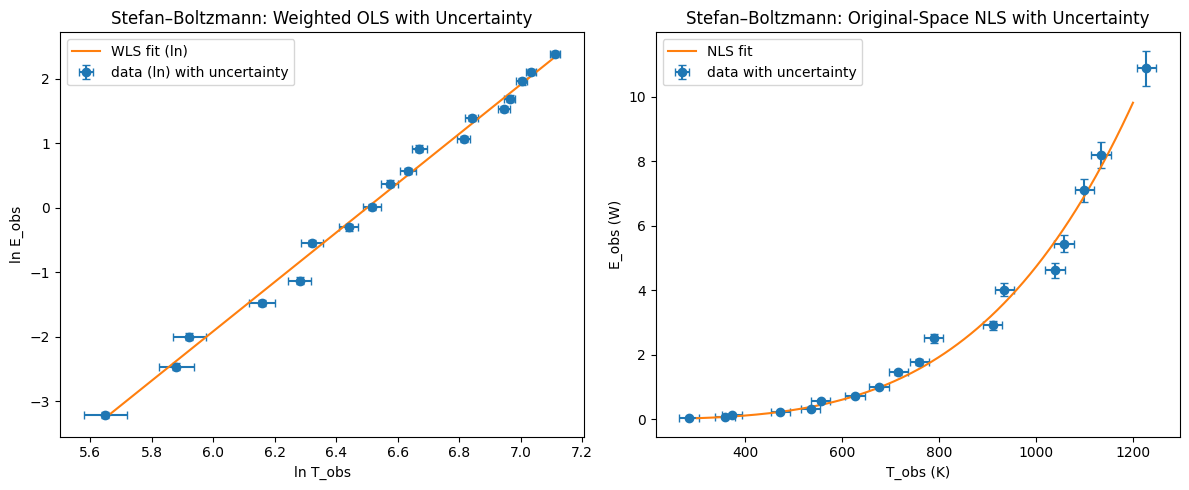

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------- CONFIG (edit me) --------------------
sigma_SB = 5.670374419e-8   # W/(m^2 K^4)
epsilon_true = 0.9
A_true = 1.0e-4             # m^2
b_true = epsilon_true * sigma_SB * A_true

rng = np.random.default_rng(9)
T_clean = np.linspace(300.0, 1200.0, 18)   # Kelvin (True temperatures)
sigma_T = 20.0 # Standard deviation of uncertainty in temperature measurement (Kelvin)
sigma_E_rel = 0.05 # Relative standard deviation of uncertainty in energy measurement (e.g., 5%)

# ----------------------------------------------------------

# Simulate observed temperatures and energies with uncertainty
T_obs = T_clean + rng.normal(0.0, sigma_T, size=T_clean.size)
E_clean = b_true * T_clean**4
# Add relative noise to E measurements
E_obs = E_clean * (1 + rng.normal(0.0, sigma_E_rel, size=E_clean.size))


# Log–log transformation
x_obs = np.log(T_obs)
y_obs = np.log(E_obs)

# Estimate variances in log-log space using error propagation
# Variance of ln(T_obs) approx (sigma_T / T_obs)^2
var_lnT = (sigma_T / T_obs)**2
# Variance of ln(E_obs) approx (sigma_E / E_obs)^2, where sigma_E = sigma_E_rel * E_clean
# We use E_obs for the denominator as it's the observed value, but E_clean for sigma_E calculation
# to be consistent with relative error definition.
var_lnE = (sigma_E_rel * E_clean / E_obs)**2

# Total variance in y_obs (ln E) considering uncertainty in both T and E
# Assuming uncertainties in T and E are independent
# For y = ln(f(x)), var(y) approx (f'(x)/f(x))^2 * var(x)
# Here y = ln(E) and E = b * T^4, so y = ln(b) + 4 ln T_obs
# The uncertainty in T propagates to ln(T), and the uncertainty in E is directly in E.
# A more accurate approach for errors in both variables is complex.
# As an approximation for WLS weights, we'll consider the variance in y_obs.
# The variance in y_obs comes from the variance in E_obs (transformed) and propagated variance from T_obs.
# var(ln E_obs) due to original E noise is approx (sigma_E_rel)^2
# var(ln E_obs) due to T_obs noise: E_obs = b * T_obs^4 => ln E_obs = ln b + 4 ln T_obs
# var(ln E_obs) approx (4/T_obs)^2 * var(T_obs) = 16 * (sigma_T / T_obs)**2
# Total variance in ln E_obs is roughly (sigma_E_rel)^2 + 16 * (sigma_T / T_obs)**2

# For simplicity in this WLS example, let's use the variance from E_obs as the primary weight source
# as NLS in original space is generally preferred when errors are in the dependent variable.
# If errors were truly independent and additive in ln space, we would use the combined variance.
# Given the original model E = b*T^4 with relative error in E and absolute error in T,
# a rigorous errors-in-variables model or Maximum Likelihood approach would be best.
# For demonstration of WLS, we'll calculate weights based on the variance of ln(E_obs)
# assuming the noise in E is the dominant source of variance in the log-log plot's y-axis.
# var(ln E_obs) approx (sigma_E / E_obs)^2 = (sigma_E_rel * E_clean / E_obs)^2
# We use 1 / var(ln E_obs) as weights.

# Simplified weights based on relative error in E, transformed to ln E space
weights_ln = 1.0 / (sigma_E_rel**2) # This assumes constant variance in ln(E), which is true for relative error in E

# If you wanted to try incorporating T uncertainty into the weights (more complex):
# var_lnE_total = sigma_E_rel**2 + 16 * (sigma_T / T_obs)**2
# weights_ln = 1.0 / var_lnE_total


# Weighted OLS in log-log space using curve_fit
def log_log_model(lnT, ln_b, slope):
    return ln_b + slope * lnT

# Use sigma as the standard deviation for curve_fit, which is 1/sqrt(weights)
sigma_ln = np.sqrt(1.0 / weights_ln) if np.isscalar(weights_ln) else np.sqrt(1.0 / weights_ln)

popt_ln, pcov_ln = curve_fit(log_log_model, x_obs, y_obs, p0=(np.log(b_true), 4.0), sigma=sigma_ln)

beta0_wls, beta1_wls = popt_ln
se_beta_wls = np.sqrt(np.diag(pcov_ln))

b_hat_wls = np.exp(beta0_wls)
se_b_wls_delta = b_hat_wls * se_beta_wls[0] # Delta method for SE of b_hat

print("Weighted OLS (ln E vs ln T_obs):")
print(f"Intercept (ln b): {beta0_wls:.4f} ± {1.96*se_beta_wls[0]:.4f}  => b_hat ≈ {b_hat_wls:.3e} ± {1.96*se_b_wls_delta:.3e} (approx 95% CI)")
print(f"Slope (should be ~4): {beta1_wls:.4f} ± {1.96*se_beta_wls[1]:.4f} (approx 95% CI)")


# Plotting the WLS fit
xx = np.linspace(x_obs.min(), x_obs.max(), 200)
yhat_wls = log_log_model(xx, beta0_wls, beta1_wls)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create figure and axes for side-by-side plots

# Plot 1: Log–log OLS with error bars for T and E uncertainty
# Horizontal error bars for T uncertainty (in log scale)
xerr = sigma_T / T_obs
# Vertical error bars for E uncertainty (in log scale)
yerr = sigma_E_rel # Approx error in ln(E) is relative error in E

axes[0].errorbar(x_obs, y_obs, xerr=xerr, yerr=yerr, fmt='o', capsize=3, label="data (ln) with uncertainty")
axes[0].plot(xx, yhat_wls, label="WLS fit (ln)")

axes[0].set_xlabel("ln T_obs")
axes[0].set_ylabel("ln E_obs")
axes[0].set_title("Stefan–Boltzmann: Weighted OLS with Uncertainty")
axes[0].legend()


# Original-space NLS comparison (same as before, but using noisy data)
if SCIPY_OK:
    def E_model(T, b):
        return b * T**4

    # For NLS in original space with uncertainty in both variables,
    # a more complex fitting approach is needed (e.g., orthogonal distance regression).
    # Standard curve_fit assumes errors are only in the dependent variable (E_obs).
    # We can still perform the fit, but the standard errors from pcov will only reflect
    # the uncertainty in E_obs, not the propagated uncertainty from T_obs.
    # To use weights in curve_fit for the original space, we would need weights
    # based on the variance of E_obs. If the relative error in E is constant,
    # the variance of E is proportional to E_clean^2. Weights would be 1/E_clean^2.

    # Standard NLS fit (assuming errors only in E_obs for simplicity here)
    popt_nls, pcov_nls = curve_fit(E_model, T_obs, E_obs, p0=(b_true * 0.8,))
    b_hat_nls = popt_nls[0]
    se_b_nls = np.sqrt(np.diag(pcov_nls))[0]

    print("\nOriginal-space NLS on E(T_obs) = b T_obs^4 (assuming errors only in E):")
    print(f"b_hat ≈ {b_hat_nls:.3e} ± {1.96*se_b_nls:.3e}  (approx 95% CI)")

    TT = np.linspace(T_clean.min(), T_clean.max(), 200)
    # Plot 2: Original-space NLS with error bars for T and E uncertainty
    axes[1].errorbar(T_obs, E_obs, xerr=sigma_T, yerr=sigma_E_rel * E_obs, fmt='o', capsize=3, label="data with uncertainty")
    axes[1].plot(TT, E_model(TT, b_hat_nls), label="NLS fit")
    axes[1].set_xlabel("T_obs (K)")
    axes[1].set_ylabel("E_obs (W)")
    axes[1].set_title("Stefan–Boltzmann: Original-Space NLS with Uncertainty")
    axes[1].legend()

    fig.tight_layout()
    plt.show()
else:
    print("SciPy not available; skipping original-space fit for E(T).")

## Difference between OLS on Linearized Data and NLS on Original Data

**Ordinary Least Squares (OLS) on Linearized Data**

*   **What it is:** You transform your original data and model equation so that the relationship becomes linear (e.g., taking logarithms of both sides for power laws or exponential decay). Then, you apply standard OLS to this linearized data. OLS minimizes the sum of the squared vertical distances between the data points and the fitted line *in the transformed space*.
*   **When it's appropriate:** OLS on linearized data is most appropriate when the errors (noise) in your measurements are **multiplicative** in the original space. When you take the logarithm (or other suitable transformation), multiplicative errors become additive errors in the transformed space, and OLS assumes additive, normally distributed errors with constant variance. If the residuals in the linearized space look random and have roughly constant spread, this is a good indication that linearization and OLS are suitable.
*   **Pros:**
    *   Mathematically simpler and faster to compute than NLS.
    *   Statistical properties (like confidence intervals) are well-understood and easier to calculate in the linearized space.
*   **Cons:**
    *   The transformation changes the noise structure. If the errors were additive and constant in the original space, they will not be in the linearized space, violating an assumption of OLS and potentially leading to biased parameter estimates and incorrect confidence intervals when back-transformed to the original space.
    *   Minimizing errors in the transformed space doesn't directly minimize errors in the original space. This can sometimes lead to a fit that doesn't look as good in the original units, especially if the noise is significant.
    *   Back-transforming parameter estimates (e.g., exponentiating the intercept from a log-log fit to get an estimate of the original coefficient) can introduce bias.

**Nonlinear Least Squares (NLS) on Original Data**

*   **What it is:** You fit the original nonlinear model equation directly to the original data. NLS minimizes the sum of the squared vertical distances between the data points and the fitted curve *in the original space*. It typically uses iterative optimization algorithms to find the parameter values that minimize this sum.
*   **When it's appropriate:** NLS is generally preferred when the errors (noise) in your measurements are **additive** with constant variance in the original space.
*   **Pros:**
    *   Minimizes errors directly in the space of your original measurements, which often leads to a visually better fit and more interpretable results in the original units.
    *   Doesn't require transforming the data, so you don't have to worry about how transformations alter the noise structure (unless you specifically use weighted NLS).
    *   Parameter estimates are directly in the units of your original model.
*   **Cons:**
    *   More computationally intensive than OLS and may require initial parameter guesses for the optimization algorithm to converge.
    *   Can be more sensitive to poor data quality or starting guesses.
    *   Statistical analysis (like calculating confidence intervals) can be more complex, though libraries like SciPy often handle this.

In the context of the Stefan-Boltzmann example:

*   The **log-log OLS fit** is performed on $\ln E$ vs $\ln T$. This is appropriate if the noise is multiplicative in the original $E$ values (meaning the error is a percentage of the value).
*   The **original-space NLS fit** is performed on $E$ vs $T$. This is appropriate if the noise is additive with constant variance in the original $E$ values (meaning the error is roughly the same absolute amount regardless of the $E$ value).

The choice between linearization + OLS and NLS depends on the assumed nature of the measurement errors. Often, looking at residual plots in both the transformed and original spaces can help you decide which approach is more suitable for your data. If the variance of the residuals is not constant in either space, weighted regression or more advanced methods might be necessary.